In [6]:
# 📦 Step 1: Imports & Setup
import pandas as pd
import os
import requests
import concurrent.futures
from tqdm import tqdm 
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 📂 Step 2: Parameter
CSV_PATH = "akon_postcards_public_domain.csv"
SAVE_DIR = "images/256"
os.makedirs(SAVE_DIR, exist_ok=True)

# 📄 Step 3: CSV laden
df = pd.read_csv(
    CSV_PATH,
    sep=",",
    quotechar='"',
    escapechar="\\",
    engine="python"
)
print("Anzahl der Einträge:", len(df))
df[['akon_id', 'download_link_256x256']].head()

# 🧭 Step 4: Save path Funktion definieren
def save_path():
    return SAVE_DIR

Anzahl der Einträge: 1855


In [8]:
# 🖼️ Step 5: Download-Funktion
def download_image(row):
    try:
        akon_id = row["akon_id"]
        url = row["download_link_256x256"]
        filename = f"{akon_id}.jpg"
        filepath = os.path.join(save_path(), filename)

        if not os.path.exists(filepath):
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                with open(filepath, "wb") as f:
                    f.write(r.content)
            else:
                return f"Fehler bei {url}: {r.status_code}"
    except Exception as e:
        return f"Fehler bei {row.get('akon_id', '???')}: {e}"
    return None

# 🔁 Step 6: Multithreaded Download
rows = [row for _, row in df.iterrows()]
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    errors = list(tqdm(executor.map(download_image, rows), total=len(rows)))

100%|██████████| 1855/1855 [00:51<00:00, 35.69it/s]


Ordner: images/full:   0%|          | 0/34846 [00:00<?, ?it/s]

9879 verschiedene Bildgrößen gefunden.


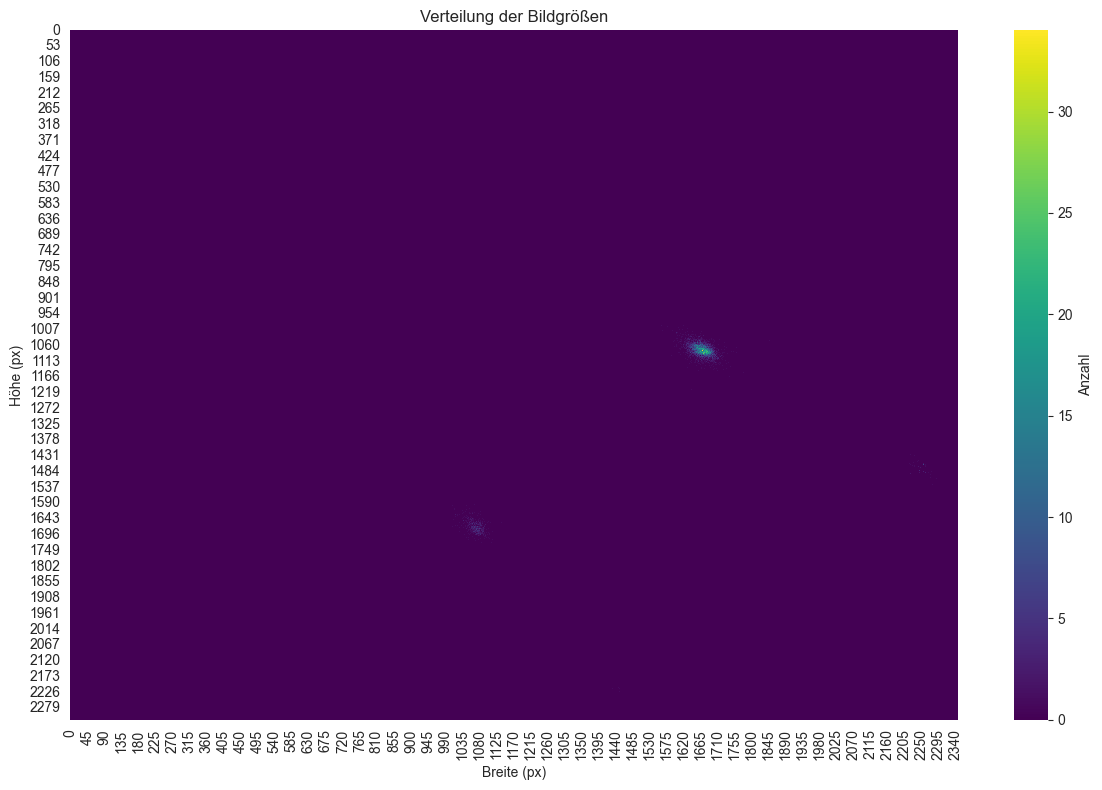


🧠 Cluster-Zentren (typische Bildgrößen):
Cluster 1: 1677 × 1080 px
Cluster 2: 1075 × 1675 px

🧠 Cluster Analyse:

Cluster 1:
 - Anzahl Bildgrößen (verschiedene): 7213
 - Gesamtanzahl Bilder (gewichtete Summe): 30553
 - Anteil am Gesamtbestand: 87.68%
 - KMeans Zentrum (Centroid): 1677 × 1080 px
 - Gewogener Mittelwert der Größen: 1677.6 × 1080.1 px
 - Varianz der Breite: 5297.9
 - Varianz der Höhe: 2608.6

Cluster 2:
 - Anzahl Bildgrößen (verschiedene): 2666
 - Gesamtanzahl Bilder (gewichtete Summe): 4293
 - Anteil am Gesamtbestand: 12.32%
 - KMeans Zentrum (Centroid): 1075 × 1675 px
 - Gewogener Mittelwert der Größen: 1075.5 × 1675.5 px
 - Varianz der Breite: 1810.1
 - Varianz der Höhe: 3486.4



KeyboardInterrupt


KeyboardInterrupt



In [ ]:
# 📚 Imports
import os
from collections import Counter
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm  # Für Fortschrittsbalken im Notebook

# 🔍 Funktion: Bildgrößen sammeln
def get_image_sizes_from_folder(folder_path):
    size_counter = Counter()
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp')

    for root, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=f"Ordner: {root}"):
            if file.lower().endswith(supported_formats):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        size = img.size  # (Breite, Höhe)
                        size_counter[size] += 1
                except Exception as e:
                    print(f"Fehler beim Öffnen von {file}: {e}")

    return size_counter

# 📊 Funktion: Heatmap anzeigen
def plot_size_heatmap(size_counter):
    sizes = list(size_counter.keys())

    if not sizes:
        print("Keine gültigen Bilder gefunden.")
        return

    widths = [w for w, h in sizes]
    heights = [h for w, h in sizes]

    max_width = max(widths)
    max_height = max(heights)

    heatmap = np.zeros((max_height + 1, max_width + 1))

    for (w, h), count in size_counter.items():
        heatmap[h][w] = count  # (Höhe, Breite)

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap, cmap='viridis', cbar_kws={'label': 'Anzahl'})
    plt.xlabel('Breite (px)')
    plt.ylabel('Höhe (px)')
    plt.title('Verteilung der Bildgrößen')
    plt.tight_layout()
    plt.show()

# 🧠 Funktion: Cluster mit KMeans berechnen
def cluster_image_sizes(size_counter, n_clusters=2):
    sizes = np.array(list(size_counter.keys()))
    weights = np.array(list(size_counter.values()))

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    kmeans.fit(sizes, sample_weight=weights)

    centroids = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    return centroids, labels, sizes

# 🖼️ Funktion: Cluster-Visualisierung
def plot_clusters(sizes, labels, centroids):
    plt.figure(figsize=(10, 6))

    for i in range(len(sizes)):
        plt.scatter(sizes[i][0], sizes[i][1], c=f"C{labels[i]}", s=10)

    for idx, (x, y) in enumerate(centroids):
        plt.scatter(x, y, c='black', marker='X', s=200, label=f'Zentrum {idx+1}')

    plt.xlabel("Breite (px)")
    plt.ylabel("Höhe (px)")
    plt.title("Bildgrößen-Clustering mit KMeans")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🎯 Erweiterte Cluster-Analyse mit mehr Statistiken
def analyze_clusters(size_counter, n_clusters=2):
    sizes = np.array(list(size_counter.keys()))
    weights = np.array(list(size_counter.values()))

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    kmeans.fit(sizes, sample_weight=weights)

    centroids = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    total_weights = weights.sum()

    print("\n🧠 Cluster Analyse:")
    for i in range(n_clusters):
        # Indizes der Punkte im Cluster i
        cluster_idx = np.where(labels == i)[0]
        # Gesamtgewicht des Clusters (Summe der Vorkommen)
        cluster_weight = weights[cluster_idx].sum()
        # Anteil in Prozent
        percent = (cluster_weight / total_weights) * 100

        # Gewogener Mittelwert der Größen im Cluster (kann vom KMeans-Zentrum abweichen)
        weighted_mean_w = np.average(sizes[cluster_idx, 0], weights=weights[cluster_idx])
        weighted_mean_h = np.average(sizes[cluster_idx, 1], weights=weights[cluster_idx])

        # Streuung (Varianz) der Bildgrößen im Cluster (optional)
        var_w = np.average((sizes[cluster_idx, 0] - weighted_mean_w) ** 2, weights=weights[cluster_idx])
        var_h = np.average((sizes[cluster_idx, 1] - weighted_mean_h) ** 2, weights=weights[cluster_idx])

        print(f"\nCluster {i+1}:")
        print(f" - Anzahl Bildgrößen (verschiedene): {len(cluster_idx)}")
        print(f" - Gesamtanzahl Bilder (gewichtete Summe): {cluster_weight:.0f}")
        print(f" - Anteil am Gesamtbestand: {percent:.2f}%")
        print(f" - KMeans Zentrum (Centroid): {centroids[i][0]} × {centroids[i][1]} px")
        print(f" - Gewogener Mittelwert der Größen: {weighted_mean_w:.1f} × {weighted_mean_h:.1f} px")
        print(f" - Varianz der Breite: {var_w:.1f}")
        print(f" - Varianz der Höhe: {var_h:.1f}")

    return centroids, labels, sizes



# ▶️ Analyse starten
folder_path = "images/full"  # <== Pfad zu deinem Bild-Ordner anpassen

# 📥 Daten sammeln
size_counter = get_image_sizes_from_folder(folder_path)
print(f"{len(size_counter)} verschiedene Bildgrößen gefunden.")

# 🔥 Heatmap anzeigen
plot_size_heatmap(size_counter)

# 🎯 KMeans-Clustering
centroids, labels, sizes = cluster_image_sizes(size_counter, n_clusters=2)

print("\n🧠 Cluster-Zentren (typische Bildgrößen):")
for i, (w, h) in enumerate(centroids):
    print(f"Cluster {i+1}: {w} × {h} px")

# 🎯 Clusteranalyse mit mehr Infos
centroids, labels, sizes = analyze_clusters(size_counter, n_clusters=2)

# 🖼️ Cluster visualisieren
plot_clusters(sizes, labels, centroids)

